In [1]:
from google.colab import files

# Opens a file upload dialog
uploaded = files.upload()



Saving RUL_FD001.csv to RUL_FD001.csv
Saving test_FD001.csv to test_FD001.csv
Saving train_FD001.csv to train_FD001.csv


In [2]:
# -*- coding: utf-8 -*-
"""CMAPSS FD001 LSTM Training in Colab"""

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [3]:
# Load the data
# ------------------------
col_names = ["engine_id", "cycle", "op_setting_1", "op_setting_2", "op_setting_3"] + [f"s{i}" for i in range(1, 22)]

train = pd.read_csv("train_FD001.csv", names=col_names, header=0)
test = pd.read_csv("test_FD001.csv", names=col_names, header=0)
rul = pd.read_csv("RUL_FD001.csv", names=["RUL"], header=0)

In [4]:
# Preprocessing
# ------------------------
# Drop duplicates if any
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

# Calculate RUL for training data
train["RUL"] = train.groupby("engine_id")["cycle"].transform(max) - train["cycle"]


/tmp/ipython-input-3680393408.py:8: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  train["RUL"] = train.groupby("engine_id")["cycle"].transform(max) - train["cycle"]


In [5]:

# Optional: normalize sensor and settings columns
feature_cols = col_names[2:]  # exclude engine_id and cycle
scaler = MinMaxScaler()
train[feature_cols] = scaler.fit_transform(train[feature_cols])
test[feature_cols] = scaler.transform(test[feature_cols])


In [6]:
# ------------------------
# Create sequences
# ------------------------
def create_sequences(df, window_size=30):
    sequences, targets = [], []
    engines = df["engine_id"].unique()
    for engine in engines:
        engine_data = df[df["engine_id"] == engine].reset_index(drop=True)
        features = engine_data[feature_cols].values
        target = engine_data["RUL"].values
        for i in range(len(engine_data) - window_size + 1):
            sequences.append(features[i:i+window_size])
            targets.append(target[i+window_size-1])
    return np.array(sequences), np.array(targets)

window_size = 30
X, y = create_sequences(train, window_size=window_size)
print("Sequence shape:", X.shape)
print("Target shape:", y.shape)


Sequence shape: (12983, 30, 24)
Target shape: (12983,)


In [7]:
# Scale targets
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1))

In [8]:
# Train/validation split
# ------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:", X_train.shape, "X_val:", X_val.shape)

X_train: (10386, 30, 24) X_val: (2597, 30, 24)


In [9]:
# LSTM Model
# ------------------------
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Predict scaled RUL
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Early stopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        78,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,857 (507.25 KB)

 Trainable params: 129,857 (507.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
# ------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=1
)


Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 0.0280 - mae: 0.1317 - val_loss: 0.0227 - val_mae: 0.1204
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - loss: 0.0230 - mae: 0.1209 - val_loss: 0.0218 - val_mae: 0.1183
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - loss: 0.0230 - mae: 0.1211 - val_loss: 0.0220 - val_mae: 0.1186
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - loss: 0.0224 - mae: 0.1191 - val_loss: 0.0221 - val_mae: 0.1190
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 0.0219 - mae: 0.1184 - val_loss: 0.0230 - val_mae: 0.1212
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - loss: 0.0226 - mae: 0.1202 - val_loss: 0.0230 - val_mae: 0.1212
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - loss: 0.0226 - mae: 0.1204 - val_loss: 0.0221 - val_mae: 0.1190
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - loss: 0.0226 - mae: 0.1204 - val_loss: 0.0229 - val_mae: 0.1209
Epoch 9/100
163/163 ━━━━

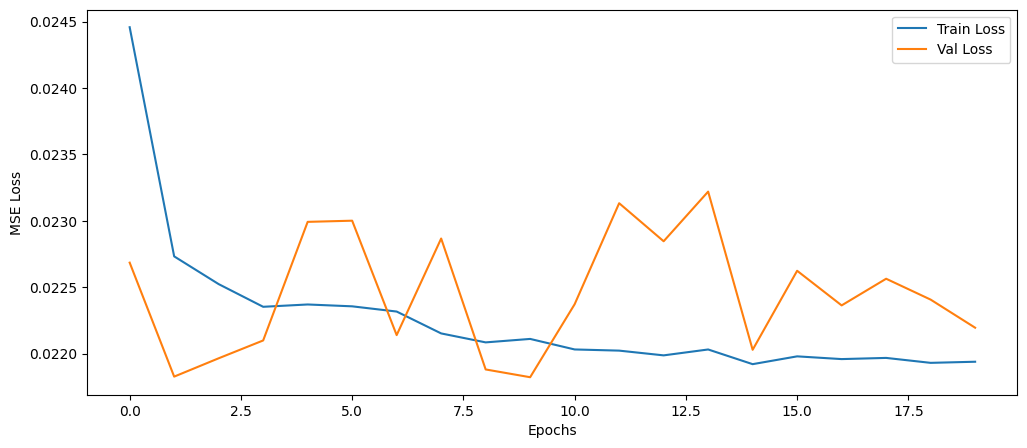

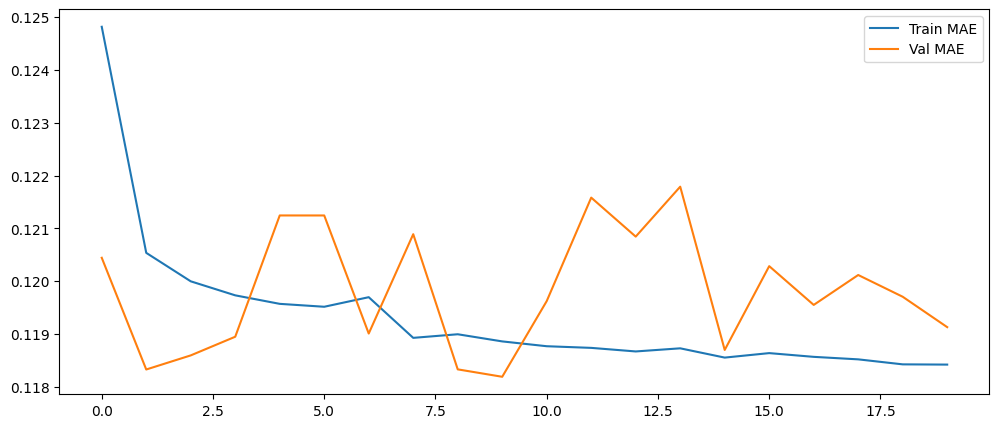

In [11]:
# Plot training history
# ------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.show()

In [12]:
# Save the model
# ------------------------
model.save("lstm_rul_model.h5")
print("Model saved as lstm_rul_model.h5")

Model saved as lstm_rul_model.h5


In [13]:
from google.colab import files
files.download("lstm_rul_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>